In [1]:
# Importing the necessary libraries
import torch

import matplotlib.pyplot as plt
from getdist import plots, MCSamples

from Network import Generator, Discriminator
from Signal_Generator import *

from tqdm import tqdm

In [2]:
# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the hyperparameters
datasize = 16000
num_sources = 1
noise_amplitude = 0

num_latent_variables = 20
learning_rate = 1e-5
weight_clip = 0.1

d_loss_threshold = -0.1
g_loss_threshold = -0.3
threshold_adjustment = 0.025
max_steps = 300

patience = 10

num_epochs = 1000

In [3]:
# Generating the dataset
dataset = []

for i in range(datasize):
    SG = Signal_Generator(num_sources=num_sources, noise_amplitude=noise_amplitude)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*datasize), int(0.2*datasize)])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [4]:
# Defining the WGAN traning class
class WGAN(torch.nn.Module):
    def __init__(self, num_latent_variables, lr, weight_clip):
        super(WGAN, self).__init__()
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def compute_losses(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        return g_loss, d_loss
    
    def train_generator(self, signal_tensor, params_tensor, z):
        g_loss, d_loss = self.compute_losses(signal_tensor, params_tensor, z)

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        g_loss, d_loss = self.compute_losses(signal_tensor, params_tensor, z)

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

  1%|▏         | 13/1000 [09:08<11:33:40, 42.17s/it]

Early stopping triggered


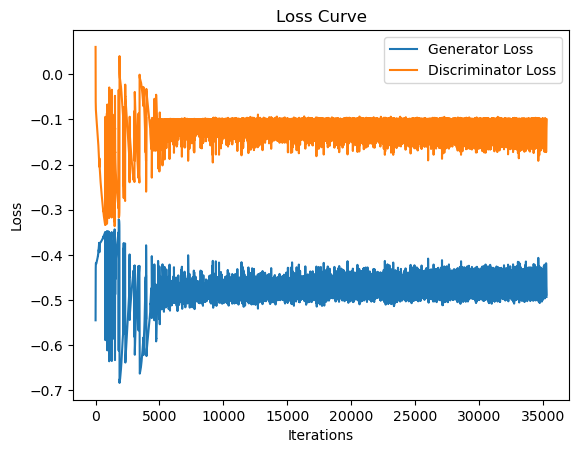

In [6]:
# Training the WGAN
wgan = WGAN(num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=weight_clip).to(device)

loss_list = []
val_loss_list = []

ncri_list = []
ngen_list = []

best_val_loss = float('inf')
patience_counter = 0

training_d = True

for epoch in tqdm(range(num_epochs)):
    ncri = 0
    ngen = 0
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        z = torch.randn(1, num_latent_variables, 1).to(device)
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)

        critic_steps = 0
        generator_steps = 0
        
        while training_d and critic_steps < max_steps:
            loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ncri+=1
            critic_steps+=1
            if loss[0] > g_loss_threshold:
                training_d = False
                break

        if critic_steps == max_steps:
            g_loss_threshold -= threshold_adjustment

        while not training_d and generator_steps < max_steps:
            loss = wgan.train_generator(signal_tensor, params_tensor, z)
            loss_list.append(loss)
            ngen+=1
            generator_steps+=1
            if loss[1] > d_loss_threshold:
                training_d = True
                break

        if generator_steps == max_steps:
            d_loss_threshold -= threshold_adjustment

    wgan.eval()
    with torch.no_grad():
        for _, (signal_tensor, params_tensor) in enumerate(val_loader):
            z = torch.randn(1, num_latent_variables, 1).to(device)
            signal_tensor = signal_tensor.to(device)
            params_tensor = params_tensor.to(device)
            
            g_loss, d_loss = wgan.compute_losses(signal_tensor, params_tensor, z)
            val_loss = (g_loss.item(), d_loss.item())

    val_loss_list.append(val_loss)

    if val_loss[0] < best_val_loss:
        best_val_loss = val_loss[0]
        patience_counter = 0
        torch.save(wgan.state_dict(), 'best_wgan_model.pt')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

    ncri_list.append(ncri)
    ngen_list.append(ngen)

plt.plot(loss_list, label=['Generator Loss', 'Discriminator Loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

In [ ]:
d_loss_threshold

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(ncri_list, label='Number of critic steps', color='blue')
axs[0].set_title('Number of critic steps')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Steps')
axs[0].legend()

axs[1].plot(ngen_list, label='Number of generator steps', color='red')
axs[1].set_title('Number of generator steps')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Steps')
axs[1].legend()

plt.tight_layout()

In [ ]:
for i in range(10):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):

        loss = wgan.train_generator(signal_tensor, params_tensor, z)
        loss_list.append(loss)

In [ ]:
generator = wgan.generator
generator.eval()

generated_params_list = []

TS = Signal_Generator(num_sources=1, noise_amplitude=1)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

for i in range(10000):
    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    generated_params_list.append(generated_params)

print(params)
print(generated_params_list)

generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])

names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels, settings={'ignore_rows': 1000})
#samples.setRanges([[-3,3],[-3,3]])
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

g = plots.get_subplot_plotter()

g.triangle_plot([generated_params_samples], filled=True)

axes = g.subplots

for i in range(len(names)):
    for j in range(i+1, len(names)):
        ax = axes[j, i]
        if ax is not None:
            ax.scatter(params[i], params[j], color='red', marker='o', s=50)

for i in range(len(names)):
    ax = axes[i, i]
    if ax is not None:
        ax.axvline(params[i], linestyle='--', color='red', lw=1)

handles = [plt.Line2D([0], [0], color='red', lw=2, linestyle='--', marker='o')]
labels = ['Original Parameters']
g.fig.legend(handles, labels, loc='upper right')

plt.show()

In [ ]:
generator = wgan.generator
generator.eval()

params_list = []
generated_params_list = []

test_times = 30
for i in range(test_times):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    #print(params)
    #print(generated_params)

actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(test_times), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(test_times), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(test_times), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(test_times), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(test_times), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(test_times), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.tight_layout()
plt.show()